# Explainability in AI

In this notebook, you will investigate one technique to explain the output of a blackbox model. You will use sklearn to implement a small pipeline applying a multilayer perceptron (vanilla feed-forward neural network) to the [sklearn breast cancer dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-wisconsin-diagnostic-dataset) and explain the feature importance in the model afterwards.

I will first demonstrate the pipeline exemplary on a [RidgeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeClassifier.html) that already ships the feature importances by construction in an interpretable format.

In [73]:
from sklearn import datasets
import matplotlib.pyplot as plt

from sklearn.linear_model import RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance

from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
!pip install -U scikit-learn
!pip install dtreeviz
import dtreeviz
import numpy as np

SEMINAR_TOPIC_NUMBER = 1
TOPIC_1_DECISION_TREE = True

## Decision Tree
Specifies the decion tree model 


## The Dataset

The Breast Cancer Dataset was introduced by [Street et al. in 1993](https://minds.wisconsin.edu/bitstream/handle/1793/59692/TR1131.pdf?sequence=1). A more detailed description can be found on the [sklearn page for the dataset](https://scikit-learn.org/stable/datasets/toy_dataset.html#breast-cancer-wisconsin-diagnostic-dataset). The data is extracted from gray-scale images of fine needle aspirate (FNA) of breast tissue. From that, the nuclei were investigated and all features relate to the nuclei in the sample tissue.

We can directly load it from sklearn and inspect it. As the dataset contains 10 predictive variables described by their mean, SE, and, worst; so, 30 variables in total. To simplify the task, we shrink down the dataset to 10 variables (we keep the variables describing the mean values).

In [74]:
data = datasets.load_breast_cancer(as_frame=True)
dataset = data['frame'].iloc[:, :10]
dataset["target"] = data['frame']['target']
dataset.columns = list(map(lambda x: x.split(" ")[-1], dataset.columns))
dataset

,radius,texture,perimeter,area,smoothness,compactness,concavity,points,symmetry,dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,0
...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,0


## Setup the Pipeline

First, we extract the X values (variable matrix) and y values (targets) from the dataset. For the demonstration, we use a RidgeClassifier as model to be explained. Set ``SEMINAR_TOPIC_NUMBER`` in the top-most cell to enable the model for your topic instead. Then, the data needs to be split into a train set and a test set. A validation set is not necessary, as we will not optimize the models. In the pipeline, we first transform the parameters to have 0 mean and standard deviation of 1. This ensures comparability of coefficients. Then, we put in the model.

Finally, we fit the pipeline and evaluate the models performance on the test set.

In [75]:
X = dataset.iloc[:, :10]
y = dataset['target']

# create models
match SEMINAR_TOPIC_NUMBER:
    case 1:
        model = DecisionTreeClassifier(criterion="gini") if TOPIC_1_DECISION_TREE else RandomForestClassifier(criterion="gini")

# prepare the pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)

0.9230769230769231

In [76]:
#check the pipeline
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', DecisionTreeClassifier())])

In [77]:
#retrivel model from pipeline
model = pipeline.named_steps['model']


### Feature Importance of decision tree
Feature Importance is a measure of how much each feature contributes to the predictions of a model. The can be used to explain the explainability of the decision tree. The more important a feature is , the greater it can affect the splits in the tree and impact the overall tree

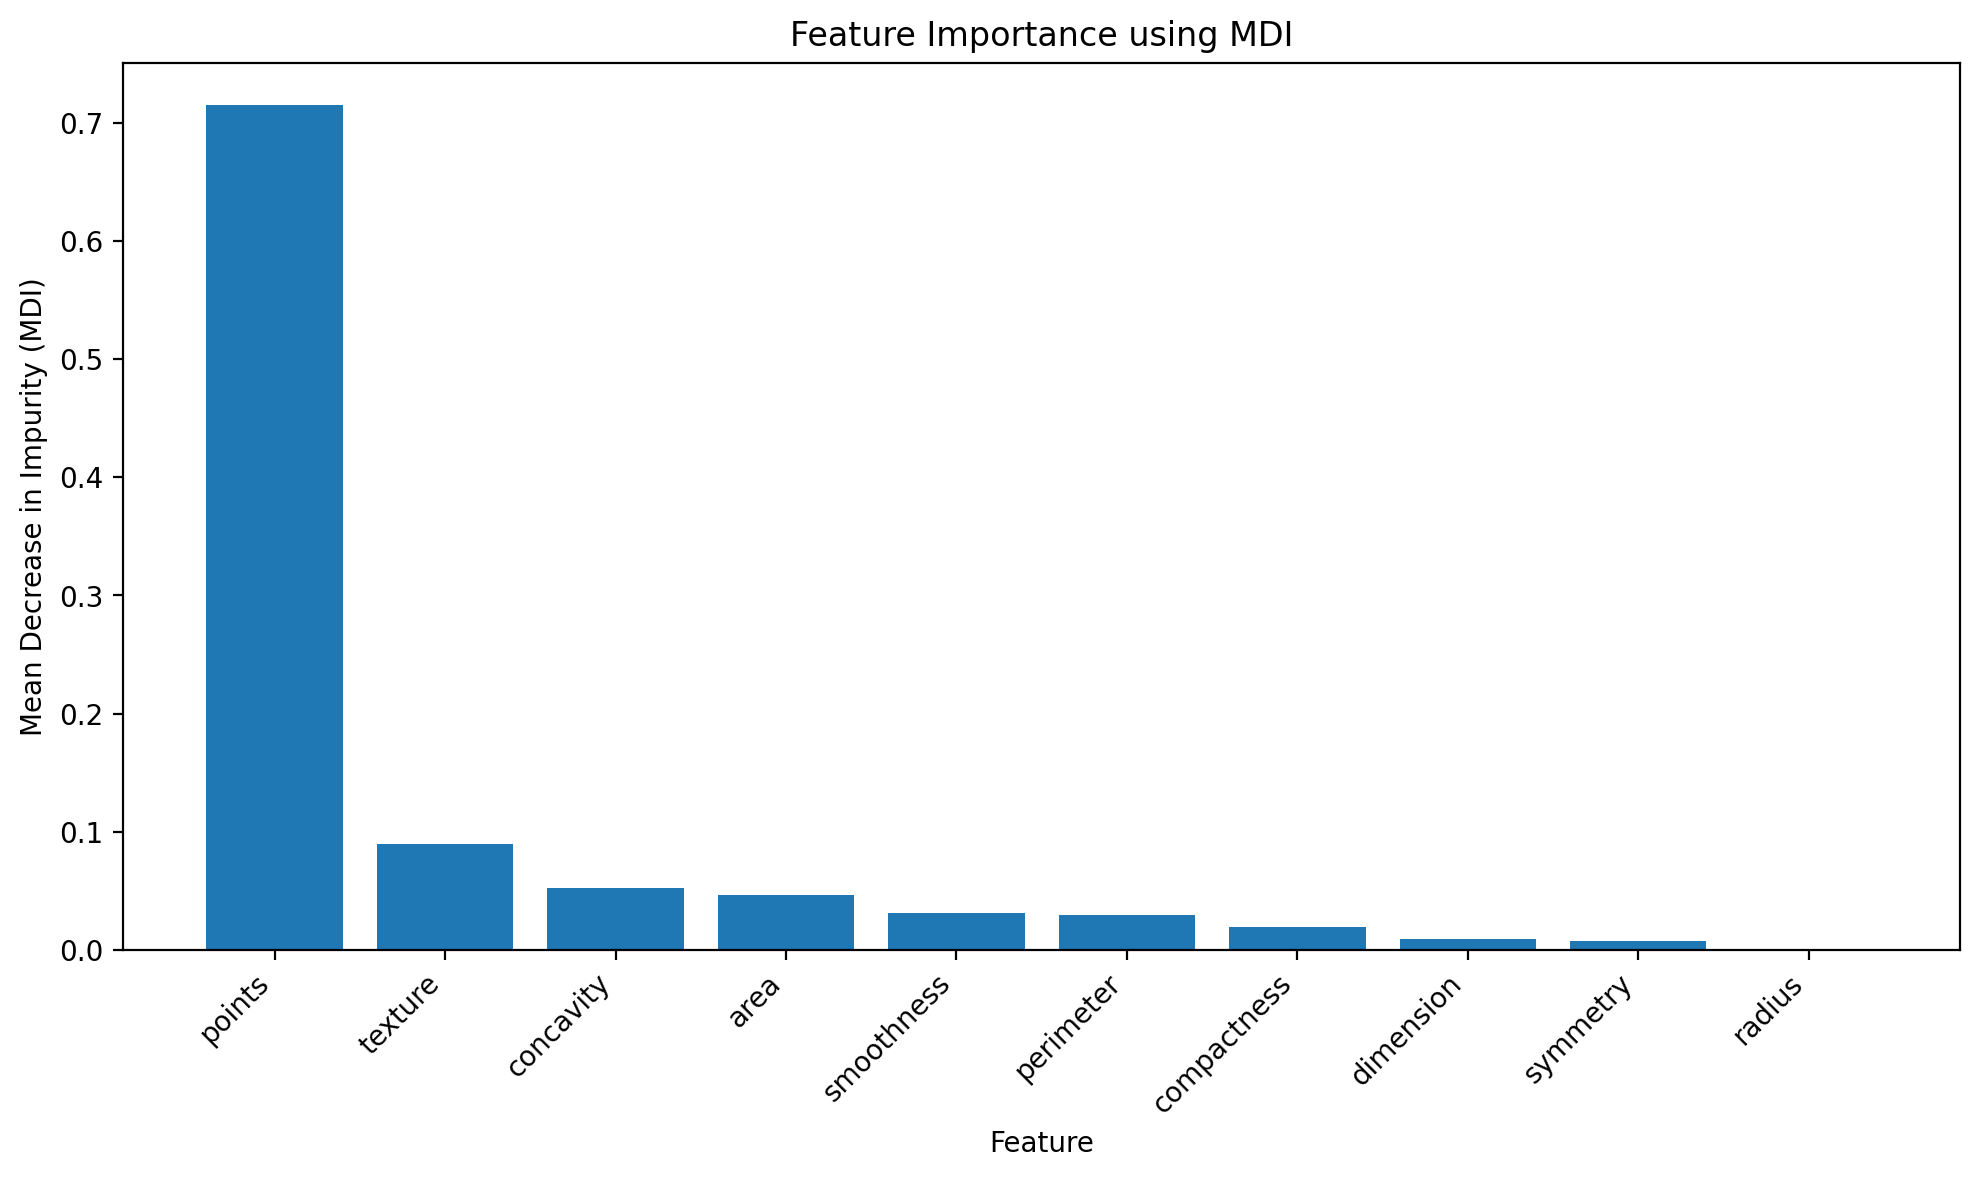

In [78]:
# Get feature importances from the model
if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier)):
    importances = model.feature_importances_
else:
    raise ValueError("Feature importances are not available for this model.")

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]

# Get feature names
feature_names = X.columns

# Create a bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=feature_names[sorted_indices])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Mean Decrease in Impurity (MDI)")
plt.title("Feature Importance using MDI")
plt.tight_layout()
plt.show()


In the above graph of Feature Importance using MDI or the mean decrease in impurity we can see that points, texture, area are all the features which are contributing the most number of splits in the tree and hence are the most important features in the tree.

### Permutation Feature Importance of decision tree
Permutation feature importance is a technique specifically designed to assess the importance of features in a model by evaluating their impact on model performance.Permutation Feature Importance works by randomly shuffle the values of a single feature while keeping the other features unchanged. 


In [79]:
# Calculate permutation importance
perm_importance = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=42)

# Get feature names
feature_names = X.columns

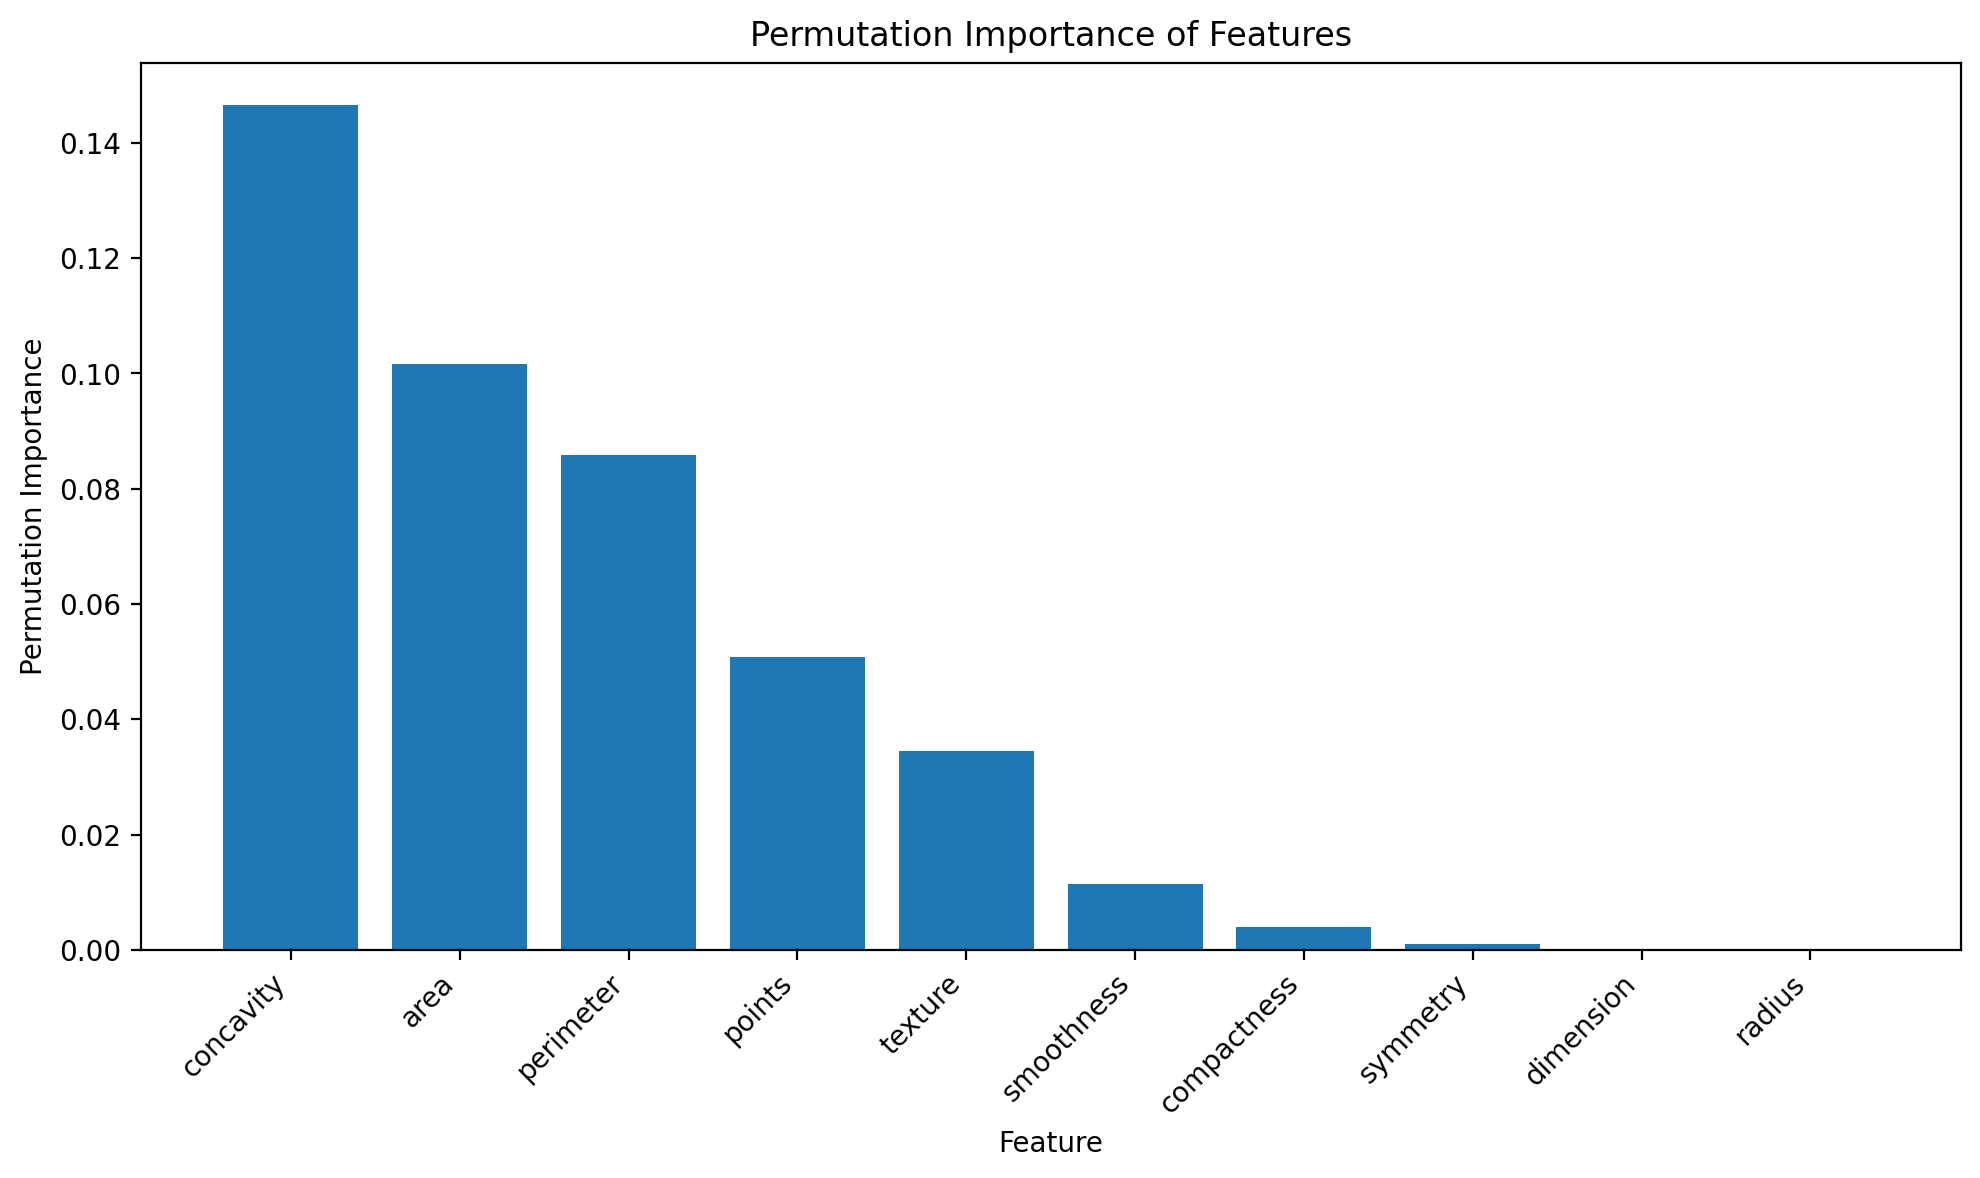

In [80]:
# Sort feature importances in descending order
sorted_indices = perm_importance.importances_mean.argsort()[::-1]
sorted_importances = perm_importance.importances_mean[sorted_indices]

# Create a bar plot for permutation importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=feature_names[sorted_indices])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Permutation Importance")
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()



In the above graph of Feature Importance using MDI or the mean decrease in impurity we can see tcertain features  are contributing the most number of splits in the tree and hence are the most important features in the tree.


In [81]:
model = pipeline.named_steps['model']  # Retrieve the model from the pipeline

### Visualization of decision tree
Visualization of the decision tree is only supported for DecisionTreeClassifier and RandomForestClassifier.
Here we can observe the diferent splits in the decisions tree and the different features which are contributing to the splits. When a prediction is made the tree is traversed from the root node to the leaf node. The leaf node is the prediction made by the tree. The path from the root node to the leaf node is the decision path. The decision path is made up of the different splits in the tree. The splits are made on the basis of the features. The features which are contributing the most to the splits are the most important features in the tree.

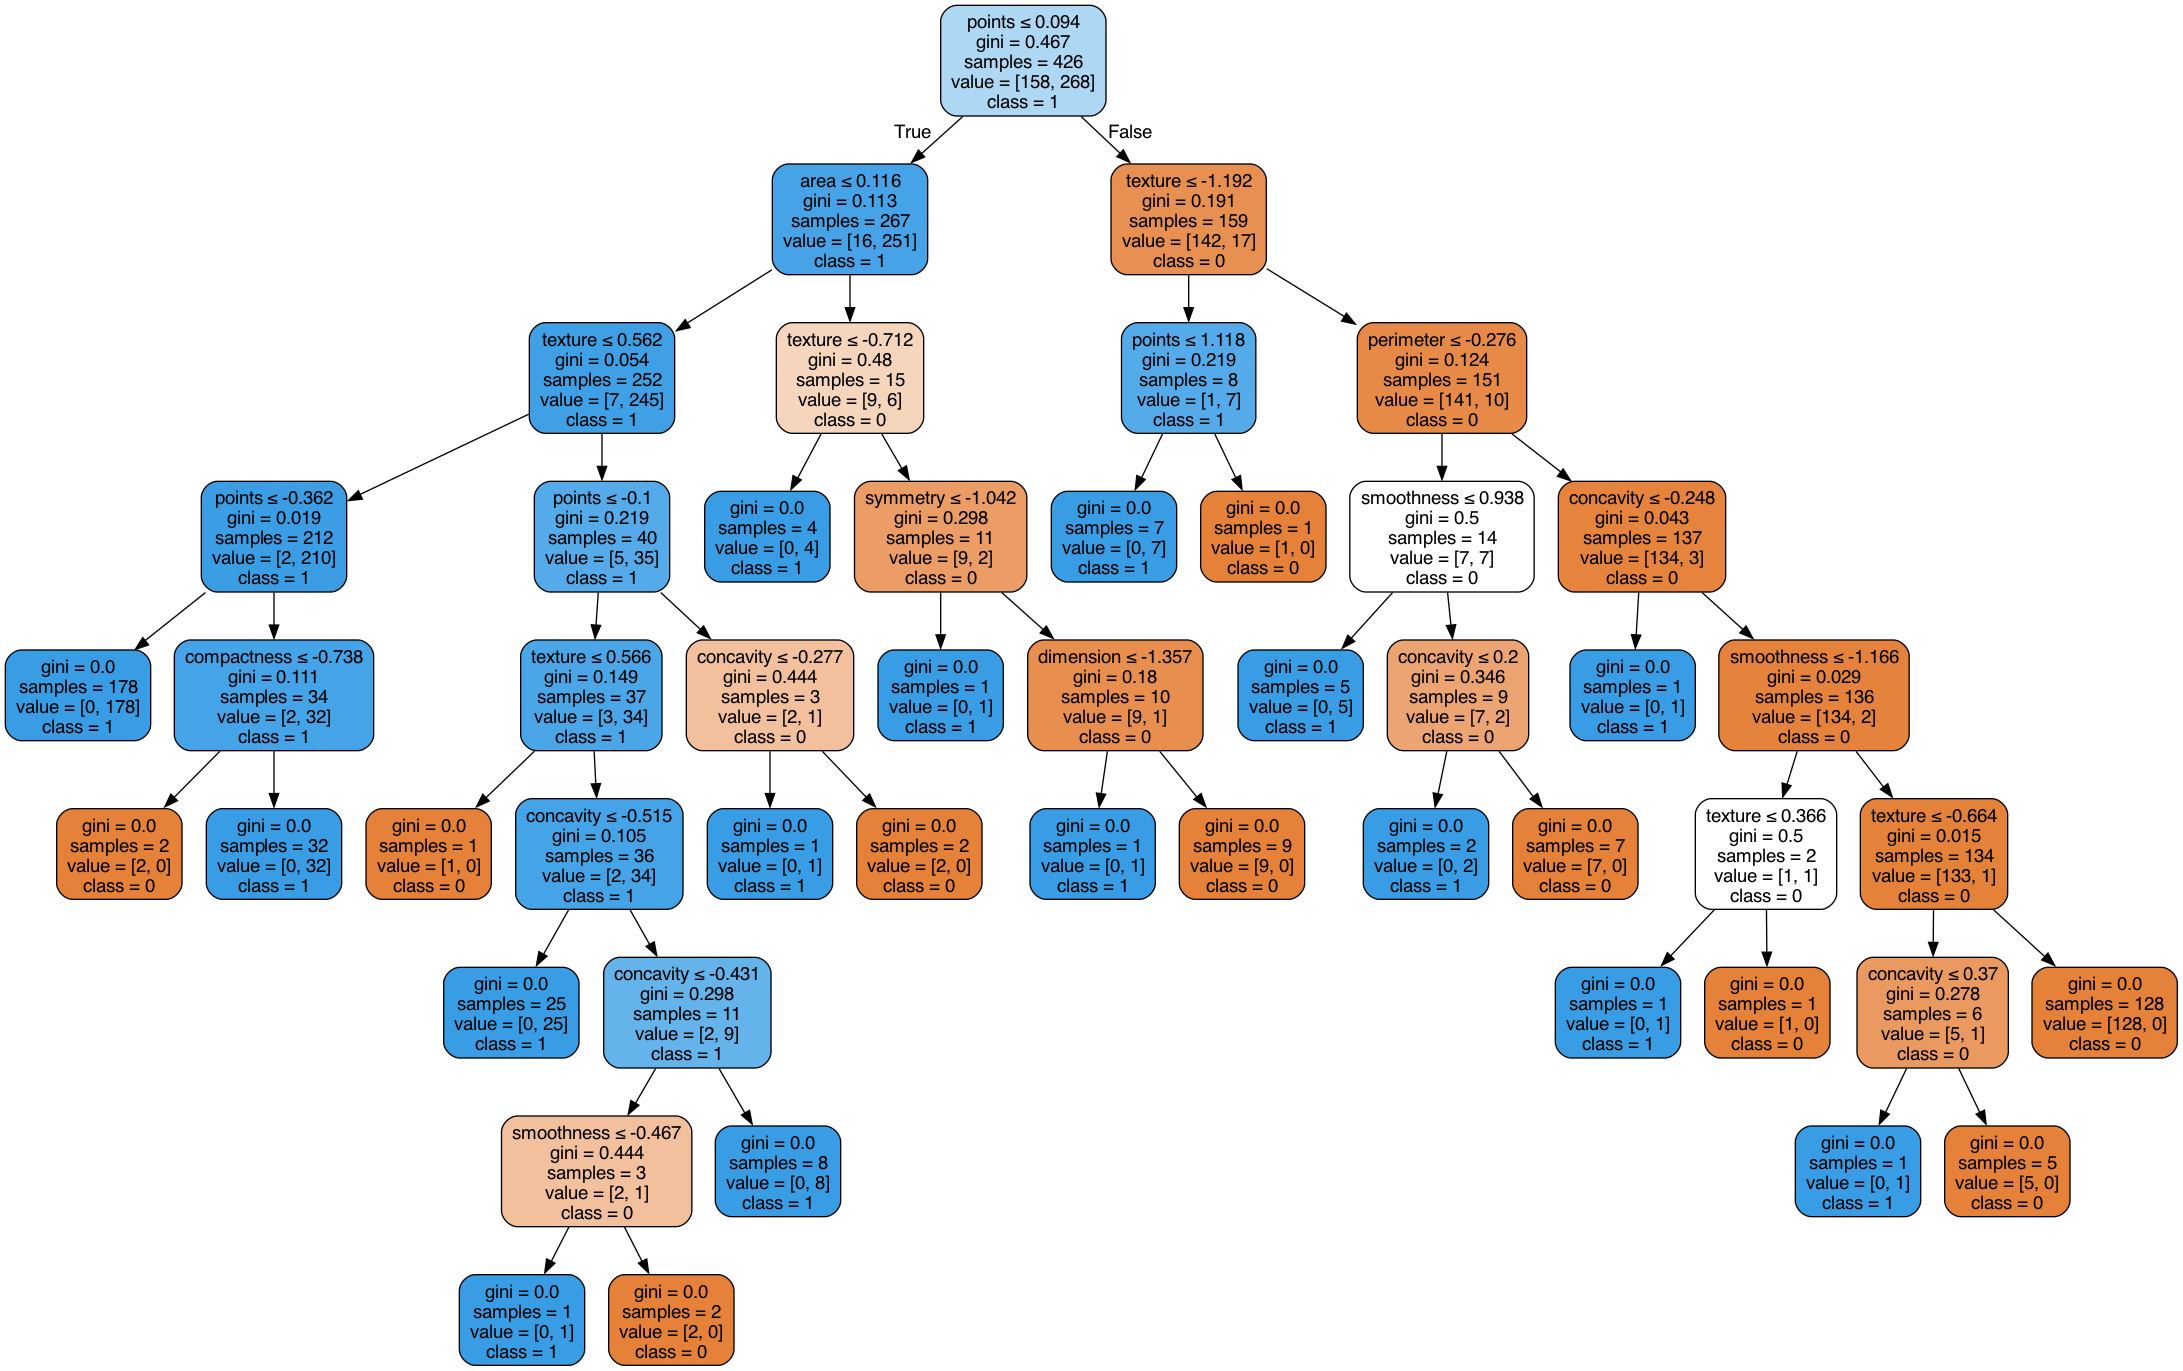

In [82]:
if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier)):
    dot_data = export_graphviz(model.estimators_[0] if isinstance(model, RandomForestClassifier) else model,
                               out_file=None,
                               feature_names=X.columns,
                               class_names=[str(cls) for cls in model.classes_],
                               filled=True,
                               rounded=True,
                               special_characters=True)

    graph = graphviz.Source(dot_data)
    graph.render("decision_tree_visualization", format="png", cleanup=True)
    display(Image(filename="decision_tree_visualization.png"))

else:
    print("Visualization is only supported for DecisionTreeClassifier and RandomForestClassifier.")





### This part of the code is experimental.
Dtreeviz is an excellent tool to visualise the decision tree classifier. it can be customised to get more information on the splits and get more information on the tree. The library is only supported for decision tree classifier and not random forest classifier. But the package is a bit finicky. The code is provided for reference only.

In [83]:
import sys
%config InlineBackend.figure_format = 'retina' # Make visualizations look good
#%config InlineBackend.figure_format = 'svg'
%matplotlib inline

In [84]:
random_state = 1234

In [85]:
#manual entry of the data as the dtreeviz library does not support the sklearn dataset
features=["radius","texture","perimeter", "area", "smoothness", "compactness","concavity", "points", "symmetry", "dimension"]
target="cancer"

In [86]:
model = DecisionTreeClassifier(criterion="gini",max_depth=3, random_state=random_state)

In [87]:
model = DecisionTreeClassifier(criterion="gini")

In [88]:
model.fit(dataset[features].values, dataset['target'].values)
# The pipeline was omitted as graphviz does not play well with it

DecisionTreeClassifier()

In [89]:
# fonts to supress warnings
!apt-get install -y fonts-liberation
!cp /usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf /usr/share/fonts/truetype/liberation/Arial.ttf

zsh:1: command not found: apt-get
cp: /usr/share/fonts/truetype/liberation/LiberationSans-Regular.ttf: No such file or directory


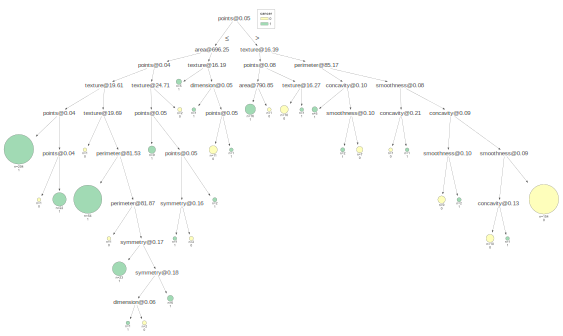

In [90]:
#dtreeviz library
plt.rcParams['font.family'] = 'DejaVu Sans'

X = dataset.drop('target', axis=1)
y = dataset['target']
viz = dtreeviz.model(model,
               X,
               y,
               target_name=target,
               feature_names=features,
               class_names=[0,1])  

viz.view(scale=5)
viz.view(fancy=False, scale=0.5)

#print only level one and two




## Random forest classifier

Random forests are a powerful ensemble learning technique in machine learning. They are used for both classification and regression tasks and are known for their ability to improve the accuracy and robustness of predictive models.The permutation feature importance and the feature importance are calculated similar to that of decision tree and the visualization is also similar to that of decision tree.The only difference is that the random forest classifier is an ensemble of decision trees and hence the feature importance and the permutation feature importance is calculated for each tree in the forest and then averaged out to get the final feature importance and permutation feature importance. The visualization is also similar to that of decision tree but the visualization is only for one tree in the forest and not the entire forest.The overall correctness of the predictions will be better than the decision tree beacuse it is more of an average of the decision trees in the forest.


In [91]:
TOPIC_1_DECISION_TREE = False

In [92]:
X = dataset.iloc[:, :10]
y = dataset['target']

# create models
match SEMINAR_TOPIC_NUMBER:
    case 1:
        model = DecisionTreeClassifier(criterion="gini") if TOPIC_1_DECISION_TREE else RandomForestClassifier(criterion="gini")
    case 2:
        model = SVC(kernel="linear")
    case 3:
        model = RidgeClassifier(alpha=0.00001, fit_intercept=False)
    case _:
        model = MLPClassifier()

# prepare the pipeline
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
pipeline = Pipeline([('scaler', StandardScaler()), ('model', model)])
pipeline.fit(X_train, y_train)
pipeline.score(X_test, y_test)


0.9440559440559441

In [93]:
# checking the pipeline
pipeline

Pipeline(steps=[('scaler', StandardScaler()),
                ('model', RandomForestClassifier())])

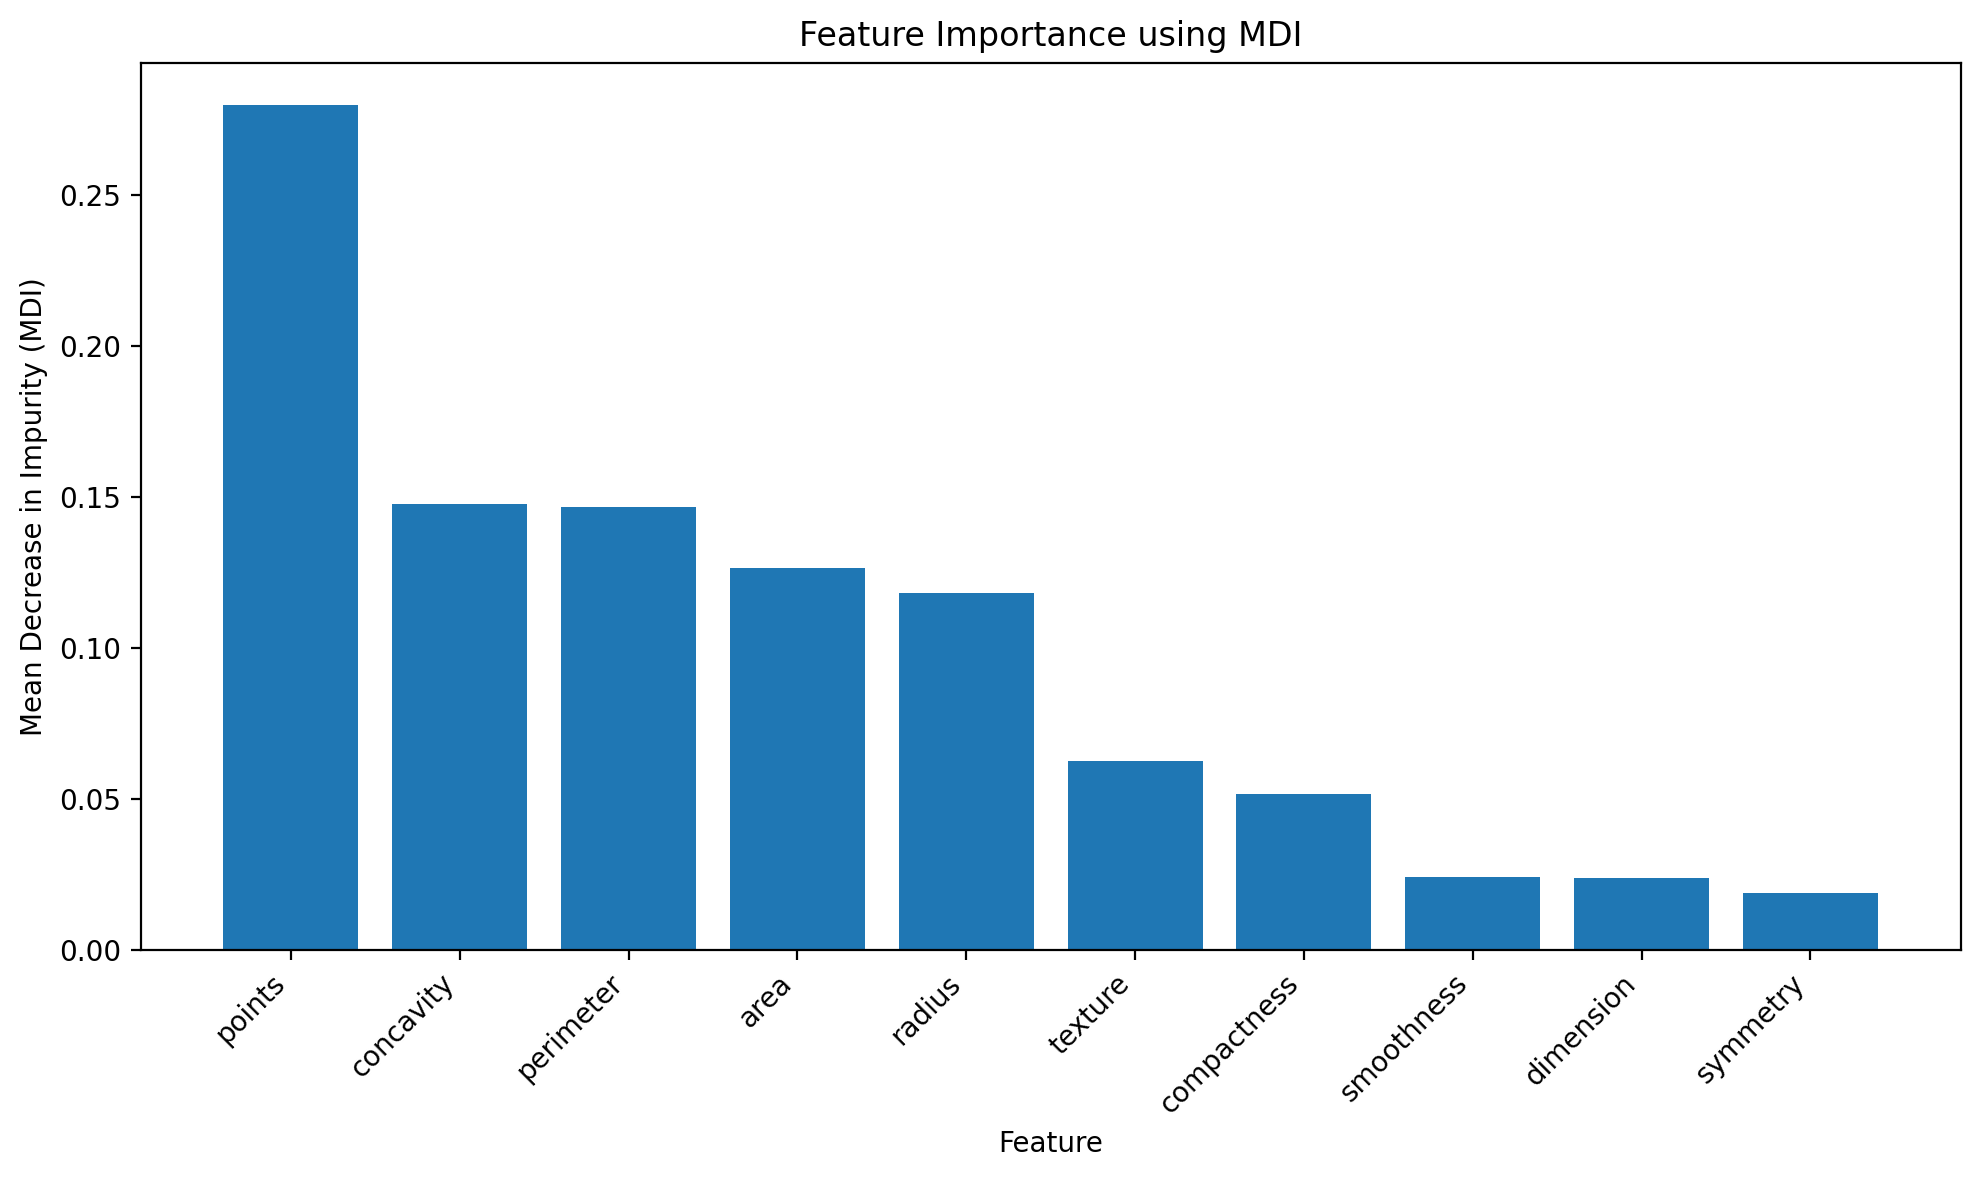

In [94]:
# Get feature importances from the model    
if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier)):
    importances = model.feature_importances_
else:
    raise ValueError("Feature importances are not available for this model.")

# Sort feature importances in descending order
sorted_indices = np.argsort(importances)[::-1]
sorted_importances = importances[sorted_indices]

# Get feature names
feature_names = X.columns

# Create a bar plot for feature importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=feature_names[sorted_indices])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Mean Decrease in Impurity (MDI)")
plt.title("Feature Importance using MDI")
plt.tight_layout()
plt.show()  

In the above graph of Feature Importance using MDI or the mean decrease in impurity we can see that points, texture, area are all the features which are contributing the most number of splits in the tree and hence are the most important features in the tree.

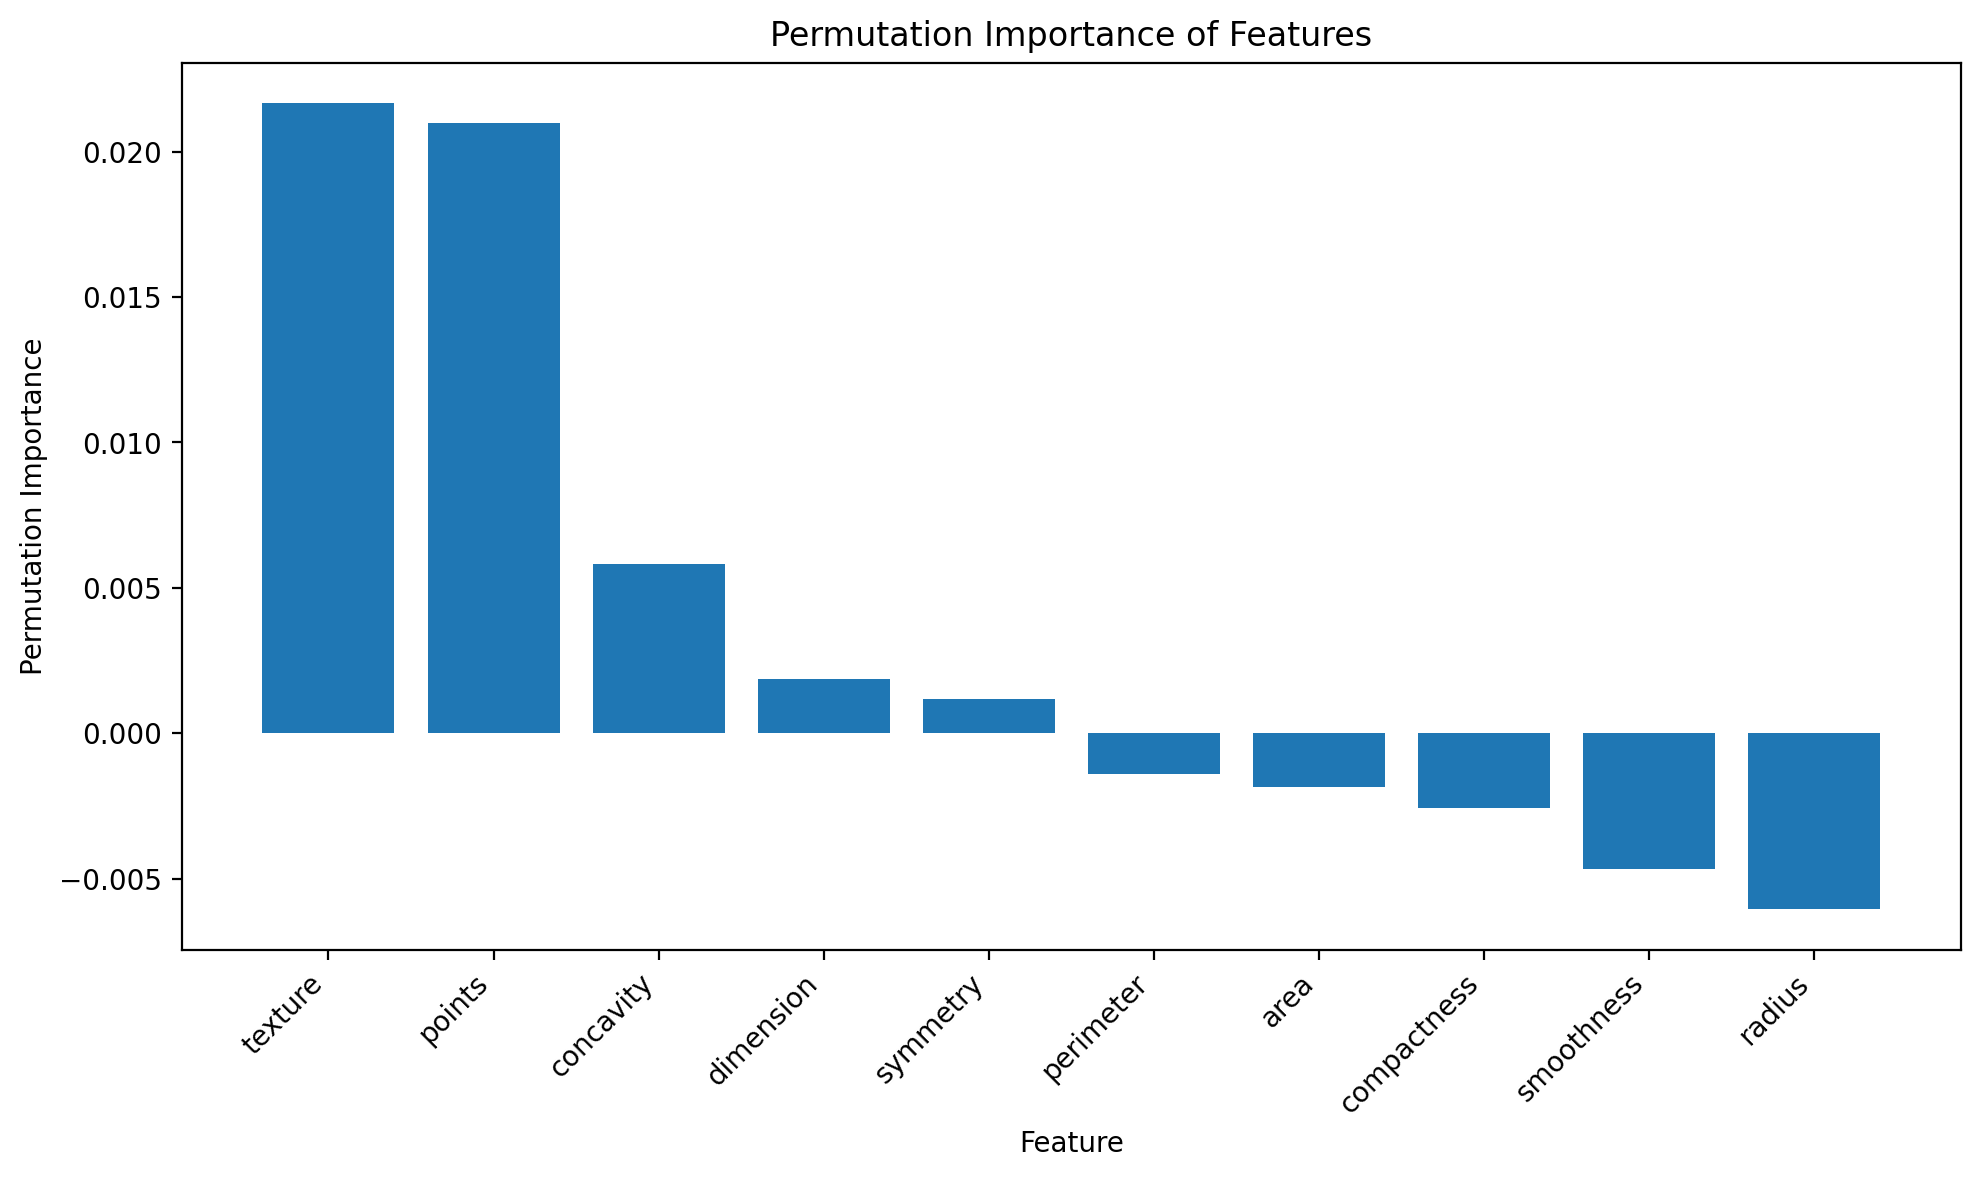

In [95]:
# Calculate permutation importance of the model
perm_importance = permutation_importance(pipeline, X_test, y_test, n_repeats=30, random_state=42)

# Get feature names
feature_names = X.columns

# Sort feature importances in descending order
sorted_indices = perm_importance.importances_mean.argsort()[::-1]
sorted_importances = perm_importance.importances_mean[sorted_indices]

# Create a bar plot for permutation importances
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_importances)), sorted_importances, tick_label=feature_names[sorted_indices])
plt.xticks(rotation=45, ha="right")
plt.xlabel("Feature")
plt.ylabel("Permutation Importance")
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()

In the above graph of permutation feature importance we can see the results are similar .

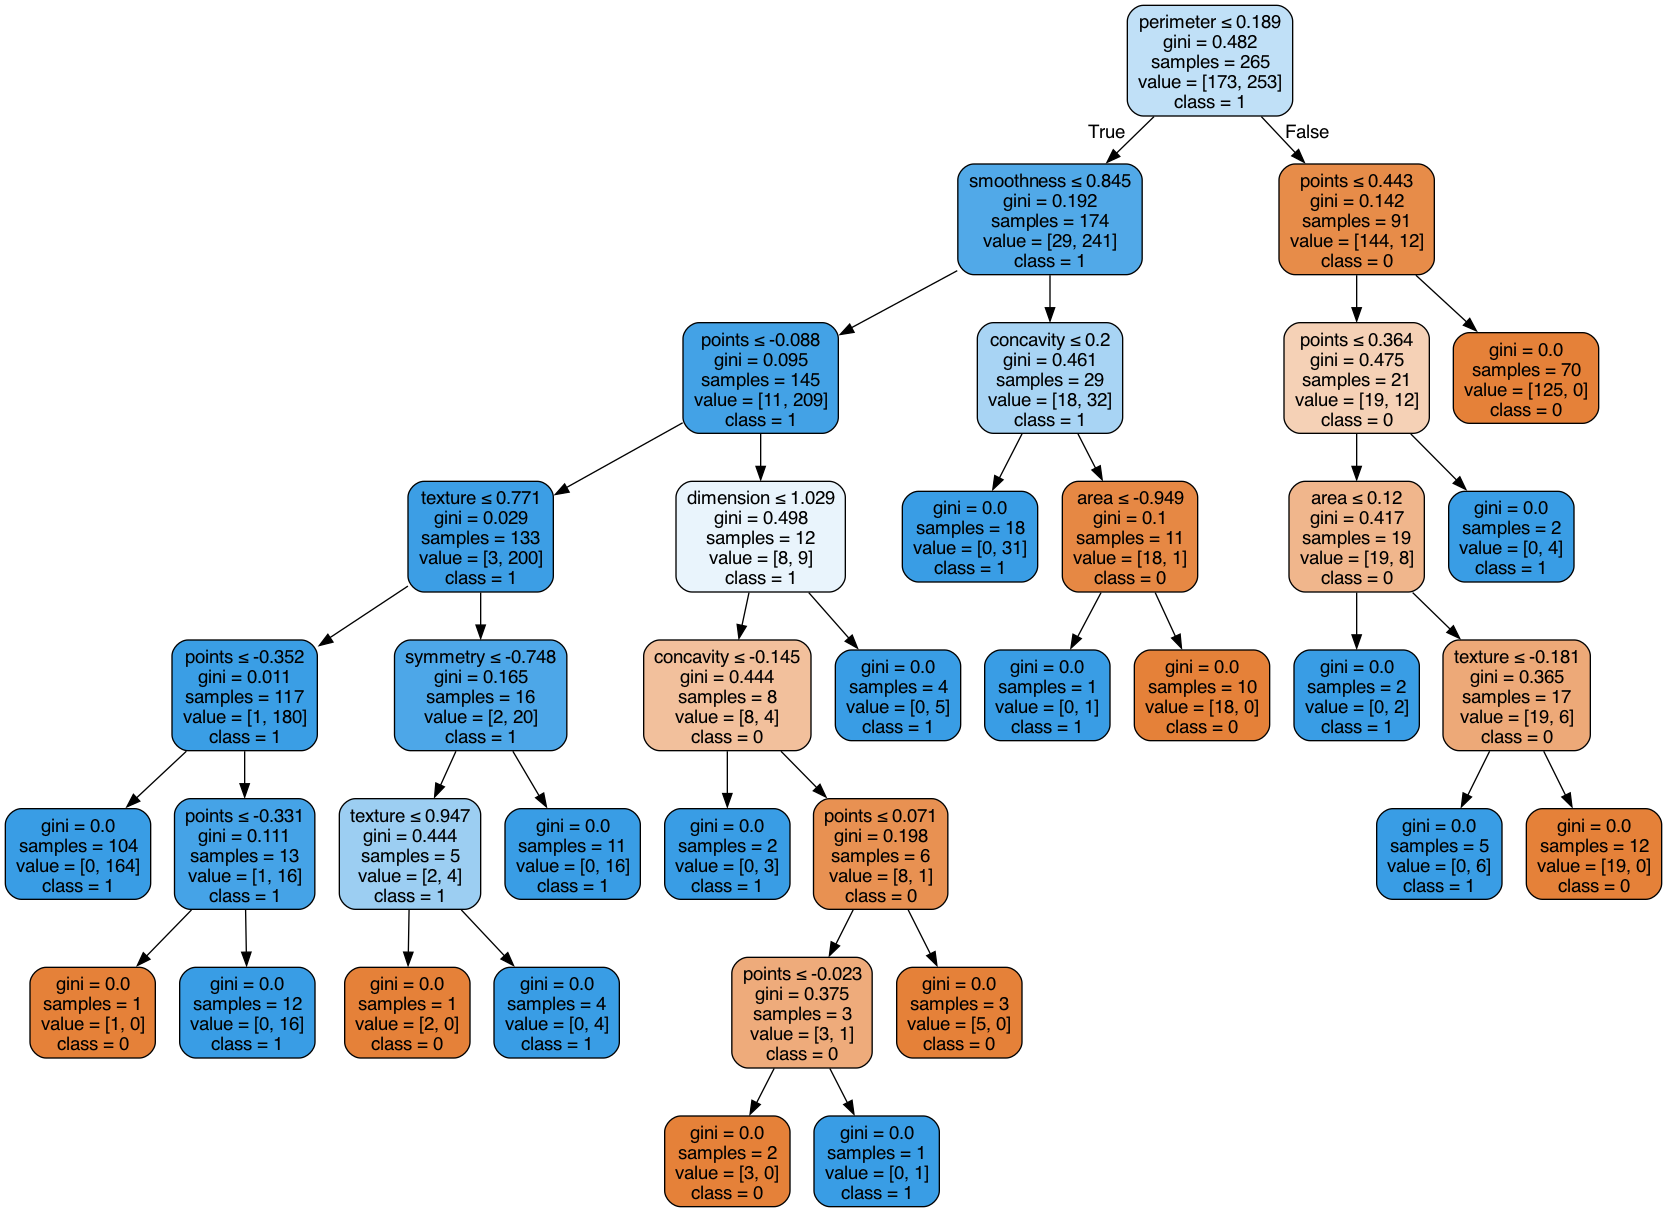

In [96]:
model = pipeline.named_steps['model']  # Retrieve the model from the pipeline

if isinstance(model, (DecisionTreeClassifier, RandomForestClassifier)):
    dot_data = export_graphviz(model.estimators_[0] if isinstance(model, RandomForestClassifier) else model,
                               out_file=None,
                               feature_names=X.columns,
                               class_names=[str(cls) for cls in model.classes_],
                               filled=True,
                               rounded=True,
                               special_characters=True)

    graph = graphviz.Source(dot_data)
    graph.render("decision_tree_visualization", format="png", cleanup=True)
    display(Image(filename="decision_tree_visualization.png"))

else:
    print("Visualization is only supported for DecisionTreeClassifier and RandomForestClassifier.")